<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Laboratorio: Construcción Modelo de Clasificación y Evaluación de Métricas

Tras realizar el preprocesamiento de los datos y dejarlos listos para construir modelos, ha llegado el momento de dar el siguiente paso: desarrollar tu **primer modelo de clasificación**.

El objetivo de este laboratorio es implementar un modelo de clasificación inicial utilizando **Regresión Logística (Logistic Regression)**. Este modelo te permitirá obtener las primeras predicciones para identificar transacciones normales y anómalas, así como evaluar su desempeño utilizando métricas estándar.

Además, deberás evaluar si el modelo está en riesgo de **overfitting**, asegurando que nuestras predicciones sean consistentes tanto en los datos de entrenamiento como en los de prueba.


## Objetivo del Laboratorio

1. Entrenar un modelo de **Regresión Logística** para predecir si una transacción es "Normal" o "Anómala".

2. Evaluar el desempeño del modelo utilizando métricas como:

   - Precisión (Accuracy).

   - Matriz de confusión.

   - Precisión (Precision), exhaustividad (Recall) y F1-Score.

   - Área bajo la curva ROC (AUC-ROC).

3. Determinar si el modelo presenta **overfitting** o **underfitting**, analizando el rendimiento en los datos de entrenamiento y prueba.


In [1]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Funciones
# -----------------------------------------------------------------------
import sys
sys.path.append('../') #pongo los 2 puntos para que salga de la carpeta
import src.funciones as f
import src.soporte_logistica_preprocesamiento as slp
import  src.soporte_ajuste_logistica as sal

# Para realizar la clasificación y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve

In [2]:
def calcular_metricas(y_train, y_test, pred_train, pred_test):
    """
    Calcula métricas de rendimiento para el modelo seleccionado.
    """

    # Métricas
    metricas_train = {
        "accuracy": accuracy_score(y_train, pred_train),
        "precision": precision_score(y_train, pred_train, average='weighted', zero_division=0),
        "recall": recall_score(y_train, pred_train, average='weighted', zero_division=0),
        "f1": f1_score(y_train, pred_train, average='weighted', zero_division=0)
    }
    metricas_test = {
        "accuracy": accuracy_score(y_test, pred_test),
        "precision": precision_score(y_test, pred_test, average='weighted', zero_division=0),
        "recall": recall_score(y_test, pred_test, average='weighted', zero_division=0),
        "f1": f1_score(y_test, pred_test, average='weighted', zero_division=0)
    }

    return pd.DataFrame({"train": metricas_train, "test": metricas_test})

In [3]:
df = pd.read_pickle('datos/datos_modelo3.pkl').reset_index(drop=True)
df.head()

,transaction_id,customer_id,merchant_id,amount_minmax,is_fraudulent,location,purchase_category,customer_age_minmax,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa
0,1,1082,2027,0.575423,0,0.500000,0.524125,0.480769,0.0,0.0,1.0,0.0
1,2,1015,2053,0.189301,1,0.529412,0.487760,0.826923,0.0,0.0,0.0,1.0
2,3,1004,2035,0.123960,1,0.596774,0.524125,0.750000,0.0,0.0,1.0,0.0
3,4,1095,2037,0.761671,1,0.596774,0.505952,0.788462,0.0,1.0,0.0,0.0
4,5,1036,2083,0.188153,1,0.497382,0.513711,0.346154,0.0,0.0,1.0,0.0


In [4]:
df = df.drop(columns=['transaction_id', 'customer_id', 'merchant_id'])

In [5]:
df['is_fraudulent'].value_counts()

is_fraudulent
1    5027
0    4888
Name: count, dtype: int64

# Balanceo

In [6]:
# instanciamos la clase de regresión logistica
logistica = sal.AnalisisModelosClasificacion(dataframe = df, variable_dependiente = "is_fraudulent")
logistica.y_test

2833    0
8312    1
360     0
1261    1
3037    0
       ..
7501    1
1477    1
1790    0
5820    1
8738    1
Name: is_fraudulent, Length: 1983, dtype: int32

## Modelo lineal

In [7]:
# instanciamos la clase de regresión logistica
logistica = sal.AnalisisModelosClasificacion(dataframe = df, variable_dependiente = "is_fraudulent")

# llamamos a la función para ajustar el modelo
logistica.ajustar_modelo("logistic_regression")

# llamamos al metodo para obtener los resultaods de las predicciones
df_resultados = logistica.calcular_metricas(modelo_nombre =  "logistic_regression" )
df_resultados.head()

,train,test
accuracy,0.537695,0.527484
precision,0.537495,0.526709
recall,0.537695,0.527484
f1,0.536880,0.525934
kappa,0.074462,0.052462


Veamos qué dicen mis datos:
- Accuracy: como de bien predigo los casos verdaderos. (0.50) Debido a que mis clases están balanceadas, puedo afirmar que tiene una predicción de una para de cada 2 donde sea correcta. 
- Precision: como de seguro estoy de que mis valores positivos predichos son correctos. (0.25) Es cierto que tengo falsos positivos pero mi precision es baja, por lo que tengo muchos falsos positivos. Lo veo nuevamente en el heatmap.
- Recall: de todos los casos realmente positivos, cuantos acierta (0.5). En este caso no hay certeza de que acierte los casos positivos ya que no supera el 0.5
- F1: relaciona el precision con el recall. Al tener más falsos positivos que negativos, se traduce en un precision menor y un recall mayor. Esto a la vez me dice que no tengo un equilibrio entre ellos por lo que mi F1 no será muy bueno.
- Kappa: un Kappa menor que 0.6 ya indica que mis predicciones son al azar. En mi caso, un Kappa de 0.0 nos indica que mis predicciones fueron hechas al azar.

## Prueba distinta:

In [ ]:
# instanciamos la clase de regresión logistica
logistica = sal.AnalisisModelosClasificacion(dataframe = df, variable_dependiente = "is_fraudulent")

# llamamos a la función para ajustar el modelo
logistica.ajustar_modelo("random_forest")

# llamamos al metodo para obtener los resultaods de las predicciones
df_resultados = logistica.calcular_metricas(modelo_nombre =  "random_forest" )
df_resultados.head()

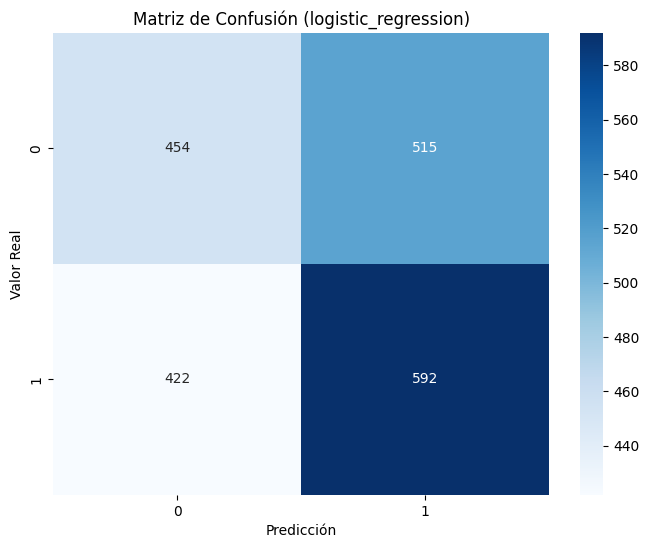

In [8]:
logistica.plot_matriz_confusion('logistic_regression')

In [9]:
x = df.drop(columns='is_fraudulent')
y = df['is_fraudulent']

In [10]:
x_train, x_test,y_train, y_test = train_test_split(x,y,train_size=0.7, random_state=42, shuffle=True)
modelo_logistica = LogisticRegression()
modelo_logistica.fit(x_train,y_train)

y_pred_test = modelo_logistica.predict(x_test)
y_pred_test[:10]
y_pred_train = modelo_logistica.predict(x_train)

y_pred_test_prob = modelo_logistica.predict_proba(x_test)[:,1] # probabilidad de esa predicción

In [11]:
calcular_metricas(y_train, y_test, y_pred_train, y_pred_test)

,train,test
accuracy,0.540490,0.516975
precision,0.540497,0.515841
recall,0.540490,0.516975
f1,0.538770,0.514655


In [12]:
regressor = LogisticRegression()
regressor.fit(x_train, y_train)

LogisticRegression()

In [13]:
print('Prediccion', y_pred_test[:3])
print('Probabiliadad de predicción', y_pred_test_prob[:3])

Prediccion [0 0 1]
Probabiliadad de predicción [0.44079211 0.47663517 0.5290606 ]


In [14]:
df_pred = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(y_pred_test)], axis=1) 
df_pred.columns = ['Real', 'Predicho']

In [15]:
df_pred

,Real,Predicho
0,0,0
1,1,0
2,0,1
3,1,1
4,0,1
...,...,...
2970,0,0
2971,1,0
2972,1,0
2973,1,1


In [16]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_prob)

Text(8.222222222222221, 0.5, 'Reales')

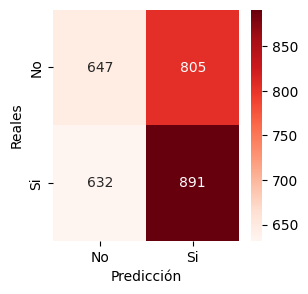

In [17]:
matriz_confusion = confusion_matrix(y_test,y_pred_test) #primero test, luego pred
plt.figure(figsize=(3,3))
etiquetas = ['No', 'Si']
sns.heatmap(matriz_confusion, 
            annot=True, # coloca números
            fmt='d',
            xticklabels=etiquetas,
            yticklabels=etiquetas,
            cmap='Reds') # formato entero
plt.xlabel(('Predicción'))
plt.ylabel(('Reales'))


In [ ]:
plt.figure(figsize=(5,3))
sns.lineplot(x=fpr, y=tpr, color='green')
sns.lineplot(x=[0,1], y=[0,1], color = 'grey')
plt.xlabel('Ratio de falsos positivos')
plt.ylabel('Ratio de verdaderos positivos')